# First Hierarachial level: Order

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize


In [1]:
# Load the dataset
file_path = '/kaggle/input/birdclef/preprocessed_data.csv'
df = pd.read_csv(file_path)

# 'Order' is the main target for stratified splitting at the top level
target_column = 'Order'

# First split: Train (70%) and Temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[target_column], random_state=42)

# Second split: Temp (30%) into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[target_column], random_state=42)

# Print the sizes to verify the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Optionally, save the splits to separate CSV files if needed
train_df.to_csv('/kaggle/working/train_data.csv', index=False)
val_df.to_csv('/kaggle/working/val_data.csv', index=False)
test_df.to_csv('/kaggle/working/test_data.csv', index=False)


Train set size: 8825
Validation set size: 1891
Test set size: 1892


In [8]:
def create_model(max_depth, n_estimators, subsample, gamma):
    model = xgb.XGBClassifier(
        objective='multi:softmax',
    num_class=17,
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    gamma=best_params['gamma'],
    tree_method='hist',  # Use hist for better compatibility, or set device='cuda' for GPU
    device='cuda',  # Set this for GPU acceleration
    eval_metric='mlogloss'  # Set evaluation metric here
)
    return model
    

In [9]:
# Define your feature columns
feature_columns = [col for col in df.columns if col.startswith('mfcc') or 
                   col.startswith('chroma') or col.startswith('spectral') or 
                   col in ['zcr_mean', 'x', 'y', 'z']]
target_column = 'Order'

X_train = train_df[feature_columns]
y_train = train_df[target_column]

# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [350, 450, 550],
    'subsample': [0.5, 0.75, 1.0],
    'gamma': [0, 0.25, 0.5],
}

# Create the model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=17)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1_macro', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'gamma': 0, 'max_depth': 10, 'n_estimators': 450, 'subsample': 0.75}
Best cross-validation score:  0.44944671790367985


In [10]:
# Retrieve the best parameters from grid search
best_params = grid_search.best_params_

# Create the best model
best_model = create_model(**best_params)

# Set early stopping rounds
best_model.set_params(early_stopping_rounds=10)

# Prepare validation data
X_val = val_df[feature_columns]
y_val = val_df[target_column]

# Fit the model with early stopping, displaying a progress bar
evals = [(X_train, y_train), (X_val, y_val)]
for _ in tqdm(range(best_params['n_estimators'])):
    best_model.fit(X_train, y_train, eval_set=evals, verbose=False)


100%|██████████| 450/450 [27:35<00:00,  3.68s/it]


In [19]:
# Prepare test data
X_test = test_df[feature_columns]
y_test = test_df[target_column]

# Make predictions on the test set
y_pred_test = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Calculate evaluation metrics
macro_f1 = f1_score(y_test, y_pred_test, average='macro')
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)

# For AUC-ROC, we need to binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')

# Print the evaluation metrics
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


Macro F1 Score: 0.5203
Balanced Accuracy: 0.4836
AUC-ROC: 0.9285


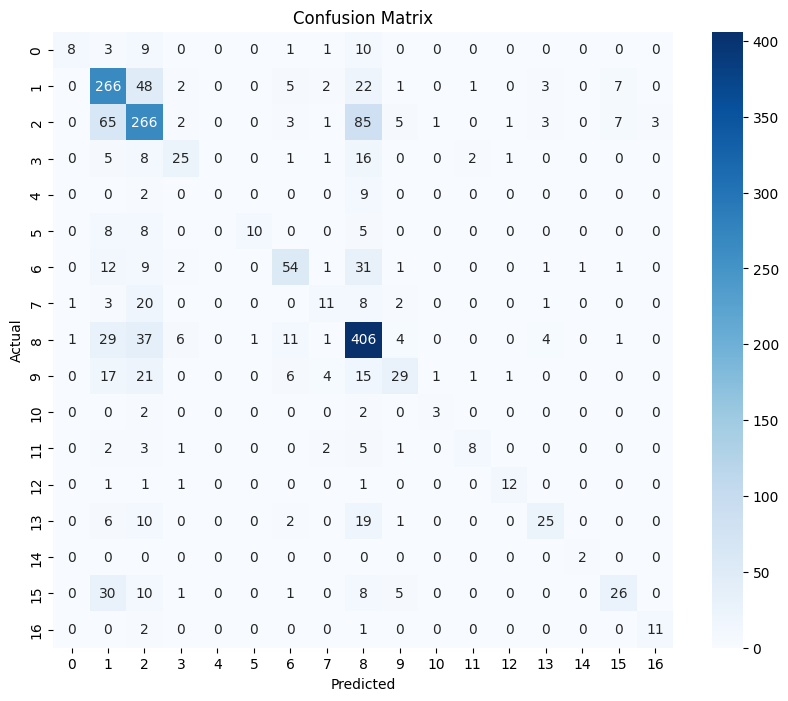

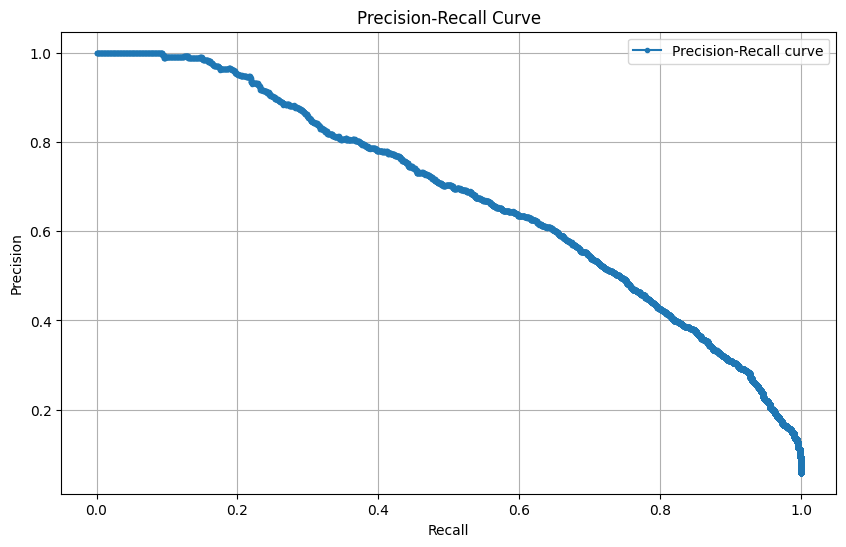

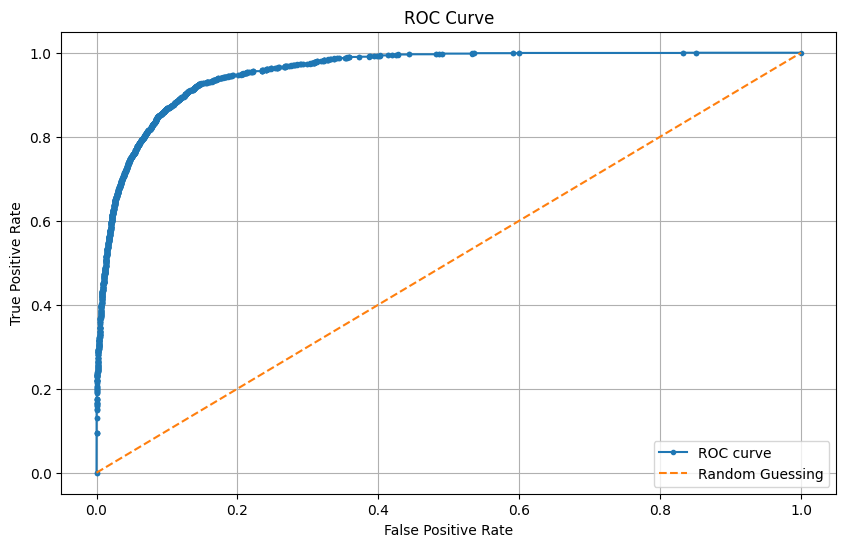

In [20]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.legend()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()


# Second Hierarachial level: Family

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/kaggle/input/birdclef/preprocessed_data.csv'
df = pd.read_csv(file_path)

# 'Family' is the main target for stratified splitting at the second level
target_column = 'Family'

# First split: Train (70%) and Temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[target_column], random_state=42)

# Second split: Temp (30%) into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[target_column], random_state=42)

# Print the sizes to verify the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")
